In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os
import glob
import torch
import utils
from scipy.special import erf
from sklearn.calibration import calibration_curve
from sklearn.metrics import (auc, brier_score_loss, confusion_matrix,
                             mean_absolute_error, mean_squared_error,
                             precision_recall_curve, r2_score, roc_curve,
							 precision_score, recall_score, f1_score,
                             mutual_info_score)
from sklearn.feature_selection import mutual_info_regression, r_regression
import utils

In [2]:
model_type = 'swmag'
shap_dir = 'outputs/shap_values'
scaler_dir = 'outputs/scalers'
results_dir = 'outputs/rsd'
VERSION = 'swmag_v6-1'
shap_files = glob.glob(f'{shap_dir}/*{VERSION}*.pkl')
scaler_files = glob.glob(f'{scaler_dir}/*{VERSION}.pkl')
results_files = glob.glob(f'{scaler_dir}/*{VERSION}.feather')
with open('cluster_dict.pkl', 'rb') as f:
	cluster_dict = pickle.load(f)

In [3]:
list_of_oversampled_regions = ['GRL-1', 'GRL-2', 'SVLB', 'JPN-0']

In [4]:
results = {}
for cluster in cluster_dict.values():
	for key, region in cluster['regions'].items():
		results[key] = {}
		if key in list_of_oversampled_regions:
			results[key]['swmag_results'] = pd.read_feather(f'{results_dir}/non_twins_modeling_region_{key}_version_swmag_v6-oversampling.feather')
			results[key]['twins_results'] = pd.read_feather(f'{results_dir}/twins_modeling_region_{key}_version_twins_v_maxpooling_oversampling.feather')
		else:
			results[key]['swmag_results'] = pd.read_feather(f'{results_dir}/non_twins_modeling_region_{key}_version_swmag_v6-1.feather')
			results[key]['twins_results'] = pd.read_feather(f'{results_dir}/twins_modeling_region_{key}_version_twins_v_maxpooling.feather')
		results[key]['mean_lat'] = utils.getting_mean_lat(region['stations'])

Loading station NEW....
Loading station T19....
Loading station C10....
Loading station LET....
Loading station T03....
Loading station T43....
Loading station LET....
Loading station T03....
Loading station T43....
Loading station RED....
Loading station C06....
Loading station T43....
Loading station RED....
Loading station C06....
Loading station MEA....
Loading station T36....
Loading station GHB....
Loading station SKT....
Loading station STF....
Loading station ATU....
Loading station SKT....
Loading station STF....
Loading station ATU....
Loading station GDH....
Loading station STF....
Loading station ATU....
Loading station GDH....
Loading station UMQ....
Loading station GHB....
Loading station FHB....
Loading station NAQ....
Loading station RVK....
Loading station LYC....
Loading station DON....
Loading station JCK....
Loading station HAN....
Loading station MEK....
Loading station OUJ....
Loading station NUR....
Loading station MAS....
Loading station NOR....
Loading station 

In [5]:
swmag_auc, maxpool_auc, mean_lat = [], [], []
for key in results.keys():

	prec, rec, __ = precision_recall_curve(y_true=results[key]['swmag_results']['actual'], probas_pred=results[key]['swmag_results']['predicted_mean'])
	swmag_auc.append(auc(rec, prec))
	prec, rec, __ = precision_recall_curve(y_true=results[key]['twins_results']['actual'], probas_pred=results[key]['twins_results']['predicted_mean'])
	maxpool_auc.append(auc(rec, prec))
	mean_lat.append(results[key]['mean_lat'])


In [6]:
swmag_plot_df = pd.DataFrame({'mean_lat':mean_lat, 'swmag_auc':swmag_auc})
maxpool_plot_df = pd.DataFrame({'mean_lat':mean_lat, 'twins_auc':maxpool_auc})

swmag_plot_df.sort_values(by='mean_lat', inplace=True)
maxpool_plot_df.sort_values(by='mean_lat', inplace=True)

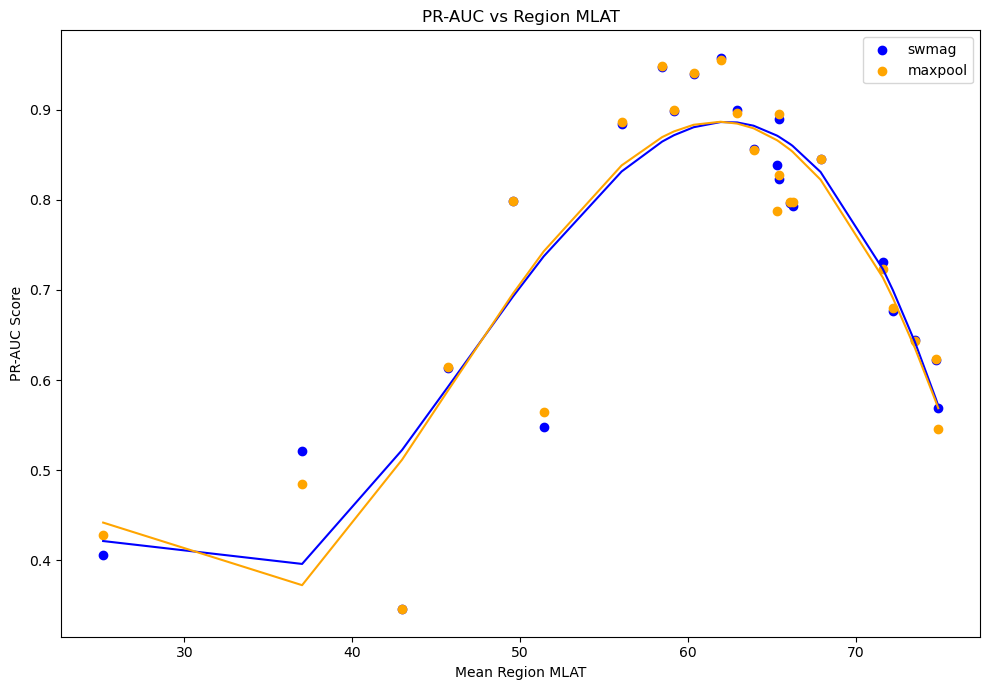

In [7]:
fig, axes = plt.subplots(1,1,figsize=(10,7))
axes.scatter(swmag_plot_df['mean_lat'], swmag_plot_df['swmag_auc'], label='swmag', color='blue')
axes.scatter(maxpool_plot_df['mean_lat'], maxpool_plot_df['twins_auc'], label='maxpool', color='orange')

swmag_z = np.polyfit(swmag_plot_df['mean_lat'], swmag_plot_df['swmag_auc'], 4)
swmag_p = np.poly1d(swmag_z)
maxpool_z = np.polyfit(maxpool_plot_df['mean_lat'], maxpool_plot_df['twins_auc'], 4)
maxpool_p = np.poly1d(maxpool_z)

axes.plot(swmag_plot_df['mean_lat'], swmag_p(swmag_plot_df['mean_lat']), color='blue')
axes.plot(maxpool_plot_df['mean_lat'], maxpool_p(maxpool_plot_df['mean_lat']), color='orange')

axes.set_xlabel('Mean Region MLAT')
axes.set_ylabel('PR-AUC Score')
axes.set_title('PR-AUC vs Region MLAT')
axes.legend()
plt.tight_layout()
plt.savefig(f'plots/pr-auc_vs_region_mlat_swmag_maxpool.png')

In [8]:
def plotting_continuious_reliability_diagram(results, model):

	''' Function that plots the reliability diagram for the predictions.'''

	x = np.linspace(0, 1, 1000)

	fig, ax = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(10,15))

	for region in results.keys():
		predictions = results[region][f'{model}_results'].dropna(inplace=False, subset=['actual', 'predicted_mean', 'predicted_std'])
		actual = predictions['actual']
		predicted_mean = predictions['predicted_mean']
		predicted_std = predictions['predicted_std'].abs()

		standard_error = (actual - predicted_mean)/(np.sqrt(2) * predicted_std).to_numpy() #Standard error for each parameter
		cumulative_dist = np.zeros((len(x), 1)) #Cumulative distribution for each parameter
		for i in standard_error.index:
			cumulative_dist[:,0] += (1/len(standard_error)) * np.heaviside(x - 0.5*(erf(standard_error.loc[i])+1) , 1) #Calculate the cumulative distribution for each parameter

		ax[0].plot(x, cumulative_dist[:,0], label=region)
		ax[1].plot(x, x - cumulative_dist[:,0], label=region)

	#Place legend to the right middle of the figure
	ax[0].legend(bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)
	ax[0].plot(x, x, linestyle = '--', color = 'k')
	ax[0].set_ylabel('Observed Frequency')
	ax[0].set_xlim(0,1)
	ax[0].set_ylim(0,1)
	fig.suptitle(f'{model} Reliability Diagram')

	ax[1].plot(x, np.zeros(len(x)), linestyle = '--', color = 'k')
	ax[1].set_ylim(-0.2,0.2)
	ax[1].set_xlabel('Predicted Frequency')
	ax[1].set_ylabel('Under/Over-\nEstimation')
	ax[1].set_aspect('equal')
	plt.subplots_adjust(hspace = -0.20)

	plt.tight_layout()
	plt.savefig(f'plots/{model}_reliability_diagram.png', bbox_inches='tight')

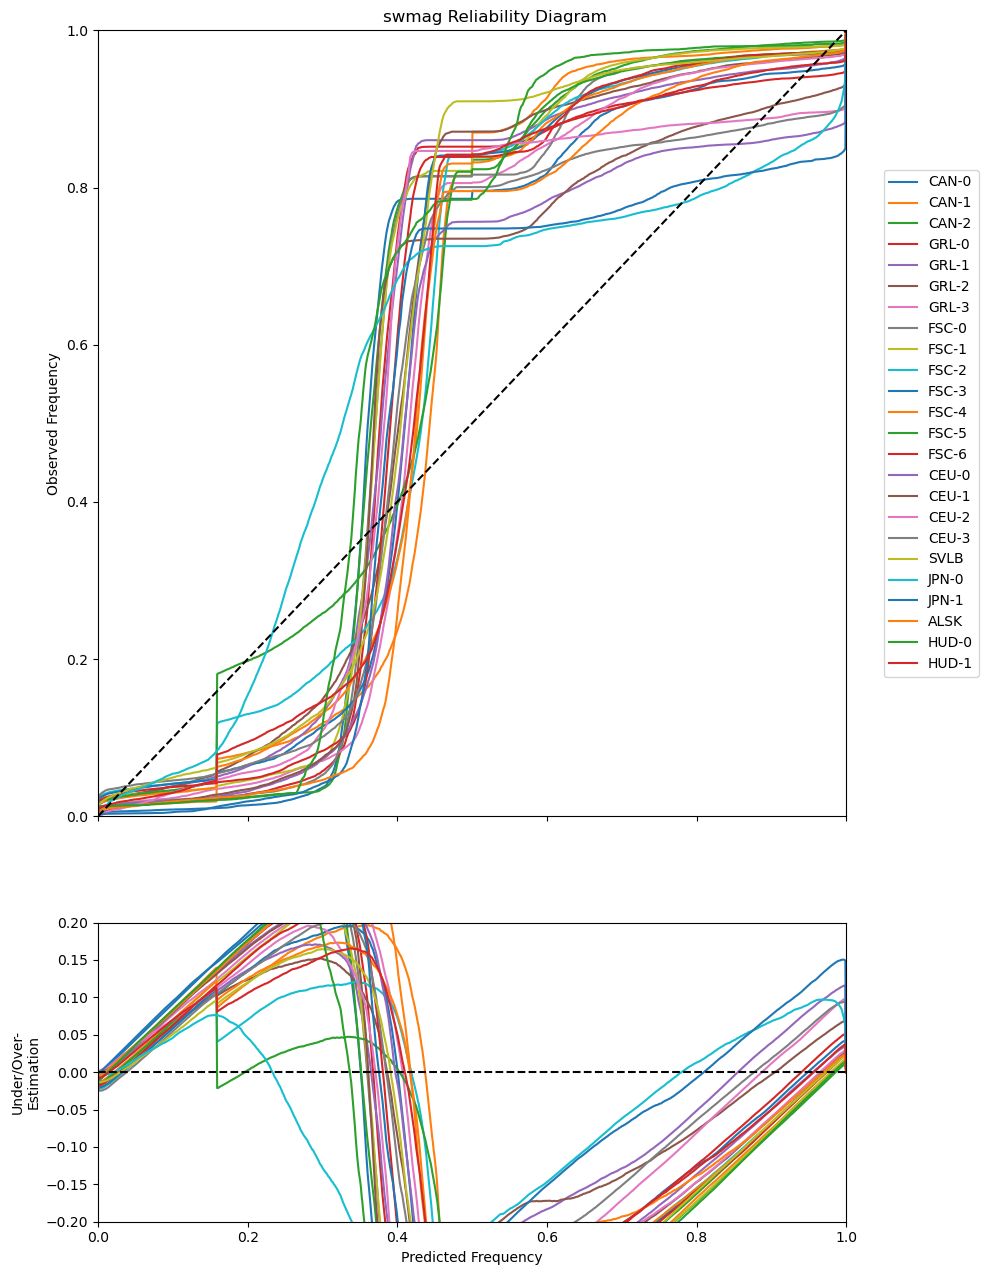

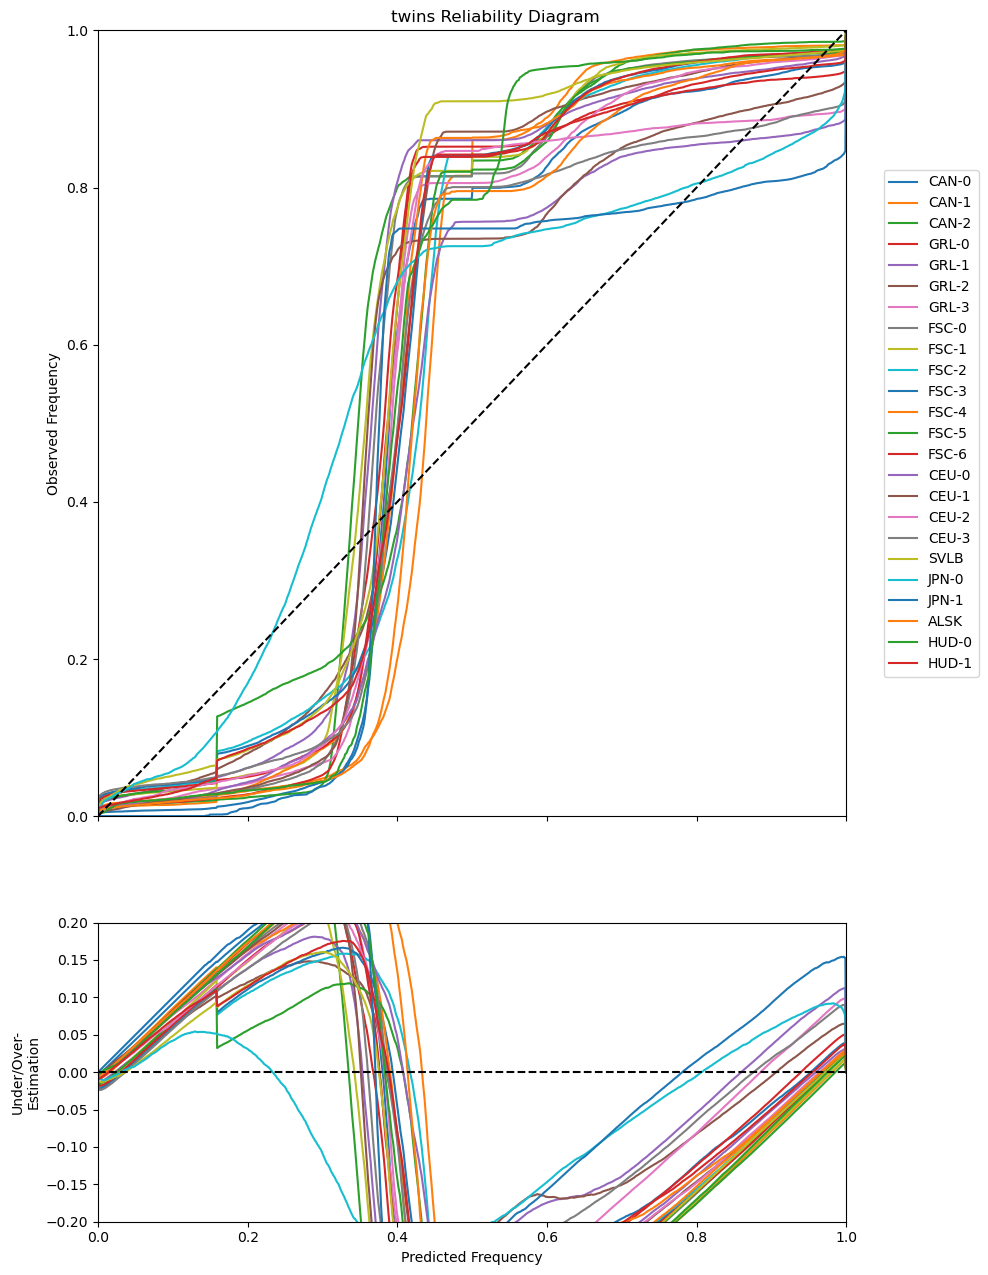

In [9]:
plotting_continuious_reliability_diagram(results, model='swmag')
plotting_continuious_reliability_diagram(results, model='twins')

In [10]:
scalers = {}
for cluster in cluster_dict.values():
	for key, region in cluster['regions'].items():
		scalers[key] = {}
		if key in list_of_oversampled_regions:
			if os.path.exists(f'{scaler_dir}/twins_{key}_twins_v_maxpooling_oversampling.pkl'):
				with open(f'{scaler_dir}/twins_{key}_twins_v_maxpooling_oversampling.pkl', 'rb') as f:
					scaler_values = pickle.load(f)
					scalers[key]['twins'] = scaler_values
			if os.path.exists(f'{scaler_dir}/swmag_{key}_swmag_v6-oversampling.pkl'):
				with open(f'{scaler_dir}/swmag_{key}_swmag_v6-oversampling.pkl', 'rb') as f:
					scaler_values = pickle.load(f)
					scalers[key]['swmag'] = scaler_values
					print(f'{key} scalers loaded')
		else:
			if os.path.exists(f'{scaler_dir}/twins_{key}_twins_v_maxpooling.pkl'):
				with open(f'{scaler_dir}/twins_{key}_twins_v_maxpooling.pkl', 'rb') as f:
					scaler_values = pickle.load(f)
					scalers[key]['twins'] = scaler_values
			if os.path.exists(f'{scaler_dir}/swmag_{key}_swmag_v6-1.pkl'):
				with open(f'{scaler_dir}/swmag_{key}_swmag_v6-1.pkl', 'rb') as f:
					scaler_values = pickle.load(f)
					scalers[key]['swmag'] = scaler_values
					print(f'{key} scalers loaded')

CAN-0 scalers loaded
CAN-1 scalers loaded
CAN-2 scalers loaded
GRL-0 scalers loaded
GRL-1 scalers loaded
GRL-2 scalers loaded
GRL-3 scalers loaded
FSC-0 scalers loaded
FSC-1 scalers loaded
FSC-2 scalers loaded
FSC-3 scalers loaded
FSC-4 scalers loaded
FSC-5 scalers loaded
FSC-6 scalers loaded
CEU-0 scalers loaded
CEU-1 scalers loaded
CEU-2 scalers loaded
CEU-3 scalers loaded
SVLB scalers loaded
JPN-0 scalers loaded
JPN-1 scalers loaded
ALSK scalers loaded
HUD-0 scalers loaded
HUD-1 scalers loaded


In [11]:
for cluster in cluster_dict.values():
	for key, region in cluster['regions'].items():
		if key in list_of_oversampled_regions:
			if os.path.exists(f'{shap_dir}/{model_type}_region_{key}_swmag_v6-oversampling.pkl'):
				with open(f'{shap_dir}/{model_type}_region_{key}_swmag_v6-oversampling.pkl', 'rb') as f:
					shap_values = pickle.load(f)
					cluster['regions'][key]['swmag_shap'] = shap_values
			# if os.path.exists(f'{shap_dir}/twins_region_{key}_twins_v_maxpooling_oversampling.pkl'):
			# 	with open(f'{shap_dir}/twins_region_{key}_twins_v_maxpooling_oversampling.pkl', 'rb') as f:
			# 		shap_values = pickle.load(f)
			# 		cluster['regions'][key]['twins_shap'] = shap_values
		else:
			if os.path.exists(f'{shap_dir}/{model_type}_region_{key}_swmag_v6-1.pkl'):
				with open(f'{shap_dir}/{model_type}_region_{key}_swmag_v6-1.pkl', 'rb') as f:
					shap_values = pickle.load(f)
					cluster['regions'][key]['swmag_shap'] = shap_values
			# if os.path.exists(f'{shap_dir}/twins_region_{key}_twins_v_maxpooling.pkl'):
			# 	with open(f'{shap_dir}/twins_region_{key}_twins_v_maxpooling.pkl', 'rb') as f:
			# 		shap_values = pickle.load(f)
			# 		cluster['regions'][key]['twins_shap'] = shap_values

In [12]:
# cluster_dict['greenland_cluster']['regions']['GRL-0']['twins_shap']['testing_data'][1].shape
print(cluster_dict['greenland_cluster']['regions']['GRL-0']['swmag_shap'].keys())

dict_keys(['shap_values', 'xtest', 'twins_test', 'ytest', 'Date_UTC', 'features'])


In [13]:
# individual_cluster_to_examine = 'canadian_cluster'
mean_shap, std_shap, X, mu, sigma, error = [], [], [], [], [], []
for cluster in cluster_dict.keys():
	for reg, region in cluster_dict[cluster]['regions'].items():
		if f'{model_type}_shap' in region.keys():

			region[f'{model_type}_shap']['mean_shap'] = np.concatenate([region[f'{model_type}_shap']['shap_values'][i][0][:,:,:,:] for i in range(len(region[f'{model_type}_shap']['shap_values']))], axis=0)
			region[f'{model_type}_shap']['std_shap'] = np.concatenate([region[f'{model_type}_shap']['shap_values'][i][1][:,:,:,:] for i in range(len(region[f'{model_type}_shap']['shap_values']))], axis=0)
			if reg in list_of_oversampled_regions:
				region[f'{model_type}_shap']['xtest'] = region['swmag_shap']['testing_data']
			else:
				region[f'{model_type}_shap']['xtest'] = region['swmag_shap']['xtest']

			for key in region[f'{model_type}_shap'].keys():
				if isinstance(region[f'{model_type}_shap'][key], torch.Tensor):
					region[f'{model_type}_shap'][key] = region[f'{model_type}_shap'][key].cpu().detach().numpy()

			region[f'{model_type}_shap']['mean_shap'] = region[f'{model_type}_shap']['mean_shap'].reshape(region[f'{model_type}_shap']['mean_shap'].shape[0], region[f'{model_type}_shap']['mean_shap'].shape[2], region[f'{model_type}_shap']['mean_shap'].shape[3])
			region[f'{model_type}_shap']['std_shap'] = region[f'{model_type}_shap']['std_shap'].reshape(region[f'{model_type}_shap']['std_shap'].shape[0], region[f'{model_type}_shap']['std_shap'].shape[2], region[f'{model_type}_shap']['std_shap'].shape[3])
			if region[f'{model_type}_shap']['xtest'].shape[1] < 3:
				region[f'{model_type}_shap']['xtest'] = region[f'{model_type}_shap']['xtest'].reshape(region[f'{model_type}_shap']['xtest'].shape[0], region[f'{model_type}_shap']['xtest'].shape[2], region[f'{model_type}_shap']['xtest'].shape[3])

			mean_added = np.sum(np.sum(np.abs(region[f'{model_type}_shap']['mean_shap']), axis=1),axis=1)
			region[f'{model_type}_shap']['mean_shap'] = region[f'{model_type}_shap']['mean_shap']/mean_added[:,None,None]

			std_added = np.sum(np.sum(np.abs(region[f'{model_type}_shap']['std_shap']), axis=1),axis=1)
			region[f'{model_type}_shap']['std_shap'] = region[f'{model_type}_shap']['std_shap']/std_added[:,None,None]

			region_scaler = scalers[reg][model_type]['swmag_scaler']

			unbroadcasted_mu = results[reg]['swmag_results']['predicted_mean'].to_numpy()
			unbroadcasted_sigma = results[reg]['swmag_results']['predicted_std'].to_numpy()
			unbroadcasted_error = np.array(np.abs(results[reg]['swmag_results']['predicted_mean'] - results[reg]['swmag_results']['actual']))

			concatenated_mu = np.concatenate([np.concatenate([unbroadcasted_mu[:,np.newaxis]]*30, axis=1)[:,:,np.newaxis]]*14, axis=2)
			concatenated_sigma = np.concatenate([np.concatenate([unbroadcasted_sigma[:,np.newaxis]]*30, axis=1)[:,:,np.newaxis]]*14, axis=2)
			concatenated_error = np.concatenate([np.concatenate([unbroadcasted_error[:,np.newaxis]]*30, axis=1)[:,:,np.newaxis]]*14, axis=2)

			mu.append(np.concatenate(concatenated_mu, axis=0))
			sigma.append(np.concatenate(concatenated_sigma, axis=0))
			error.append(np.concatenate(concatenated_error, axis=0))

			mean_shap.append(np.concatenate(region[f'{model_type}_shap']['mean_shap'], axis=0))
			std_shap.append(np.concatenate(region[f'{model_type}_shap']['std_shap'], axis=0))
			X.append(region_scaler.inverse_transform(np.concatenate(region[f'{model_type}_shap']['xtest'], axis=0)))

mean_shap = np.concatenate(mean_shap, axis=0)
std_shap = np.concatenate(std_shap, axis=0)
X = np.concatenate(X, axis=0)
mu = np.concatenate(mu, axis=0)
sigma = np.concatenate(sigma, axis=0)
error = np.concatenate(error, axis=0)

mean_shap_df = pd.DataFrame(mean_shap, columns=shap_values['features'])
std_shap_df = pd.DataFrame(std_shap, columns=shap_values['features'])
transformed_X_df = pd.DataFrame(X, columns=shap_values['features'])
mu_df = pd.DataFrame(mu, columns=shap_values['features'])
sigma_df = pd.DataFrame(sigma, columns=shap_values['features'])
error_df = pd.DataFrame(error, columns=shap_values['features'])

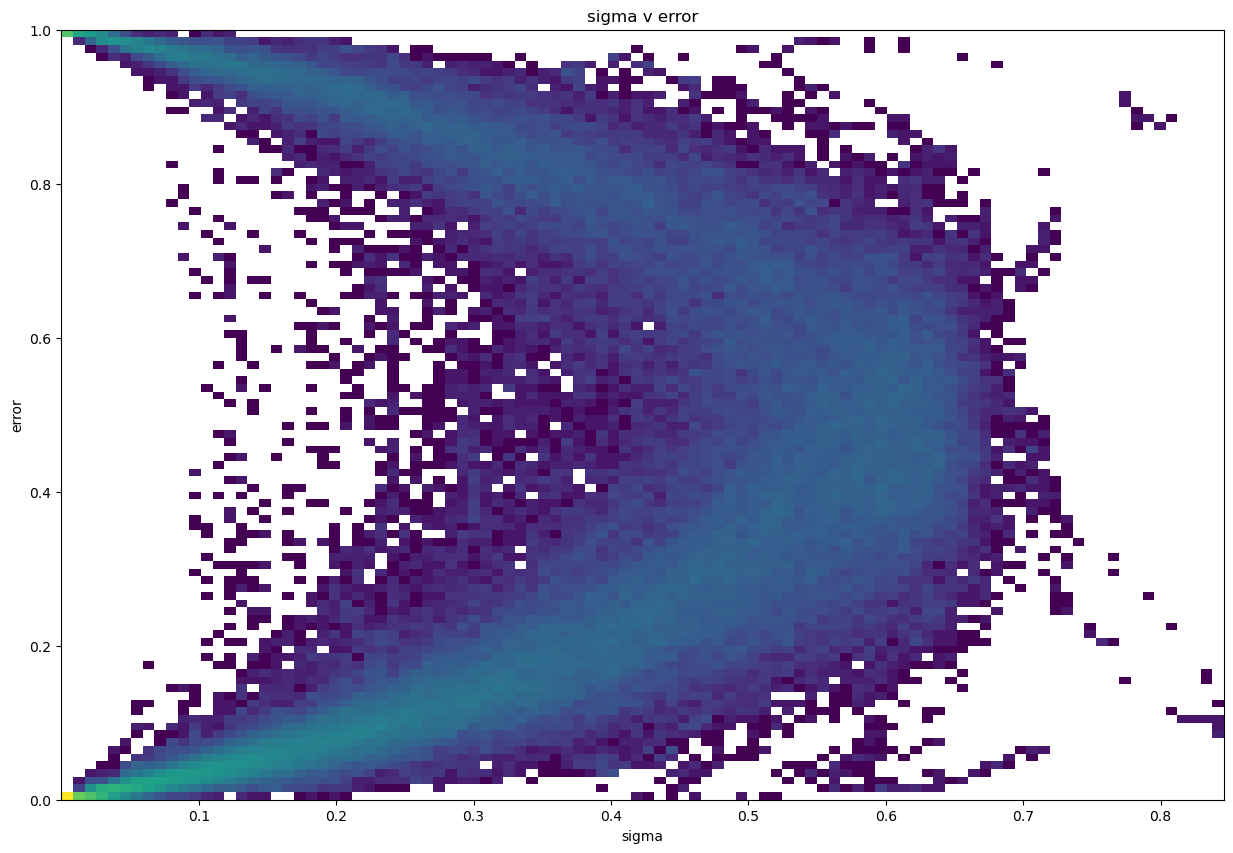

In [14]:
feature = ['Vx']

fig, axes = plt.subplots(1, len(feature), figsize=(15, 10))
for i in range(len(feature)):
	axes.hist2d(sigma_df[feature[i]], error_df[feature[i]], bins=100, cmap='viridis', norm=mpl.colors.LogNorm())
	axes.set_title('sigma v error')
	axes.set_xlabel('sigma')
	axes.set_ylabel('error')
plt.savefig('plots/swmag_sigma_vs_error.png')

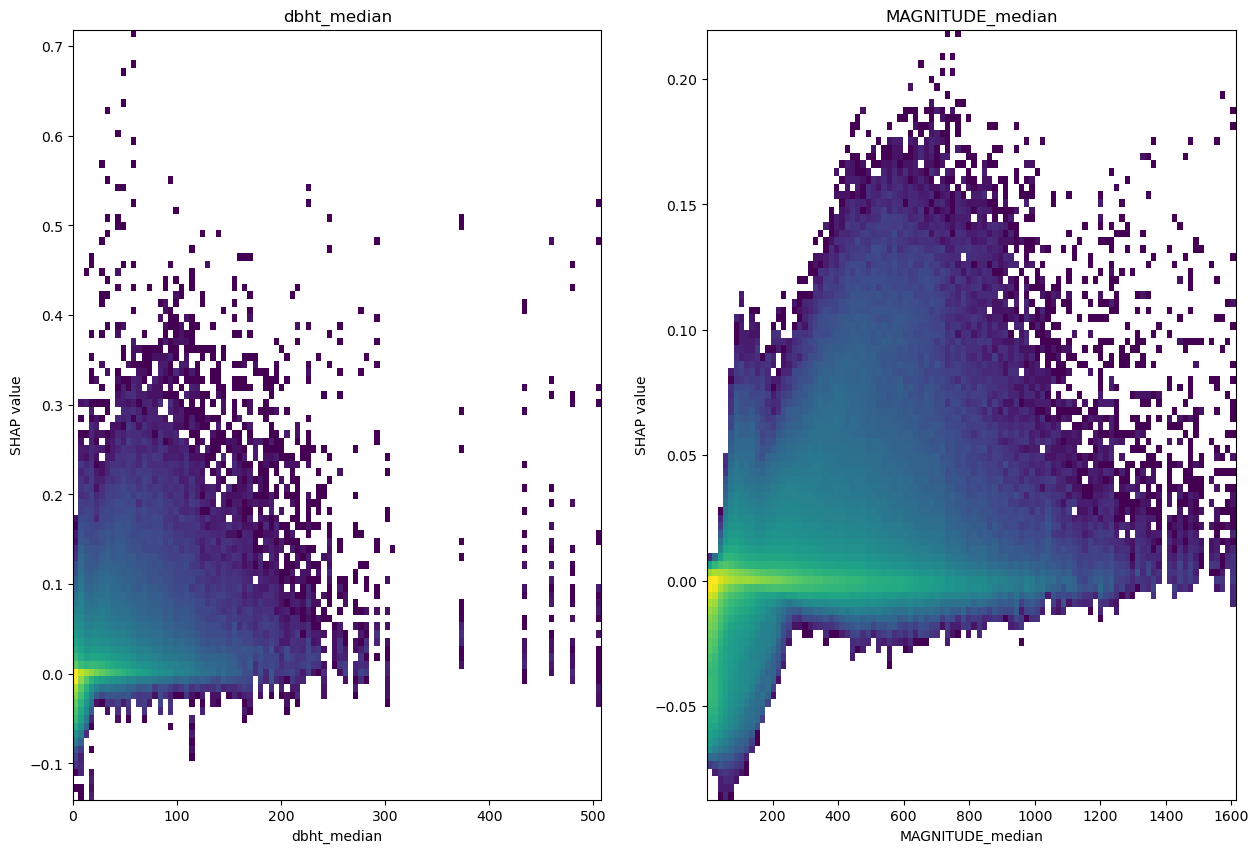

In [15]:
feature = ['dbht_median', 'MAGNITUDE_median']

fig, axes = plt.subplots(1, len(feature), figsize=(15, 10))
for i, ax in enumerate(axes):
	axes[i].hist2d(transformed_X_df[feature[i]], mean_shap_df[feature[i]], bins=100, cmap='viridis', norm=mpl.colors.LogNorm())
	ax.set_title(f'{feature[i]}')
	ax.set_xlabel(feature[i])
	ax.set_ylabel('SHAP value')
plt.savefig(f'plots/{feature[0]}_and_{feature[1]}')

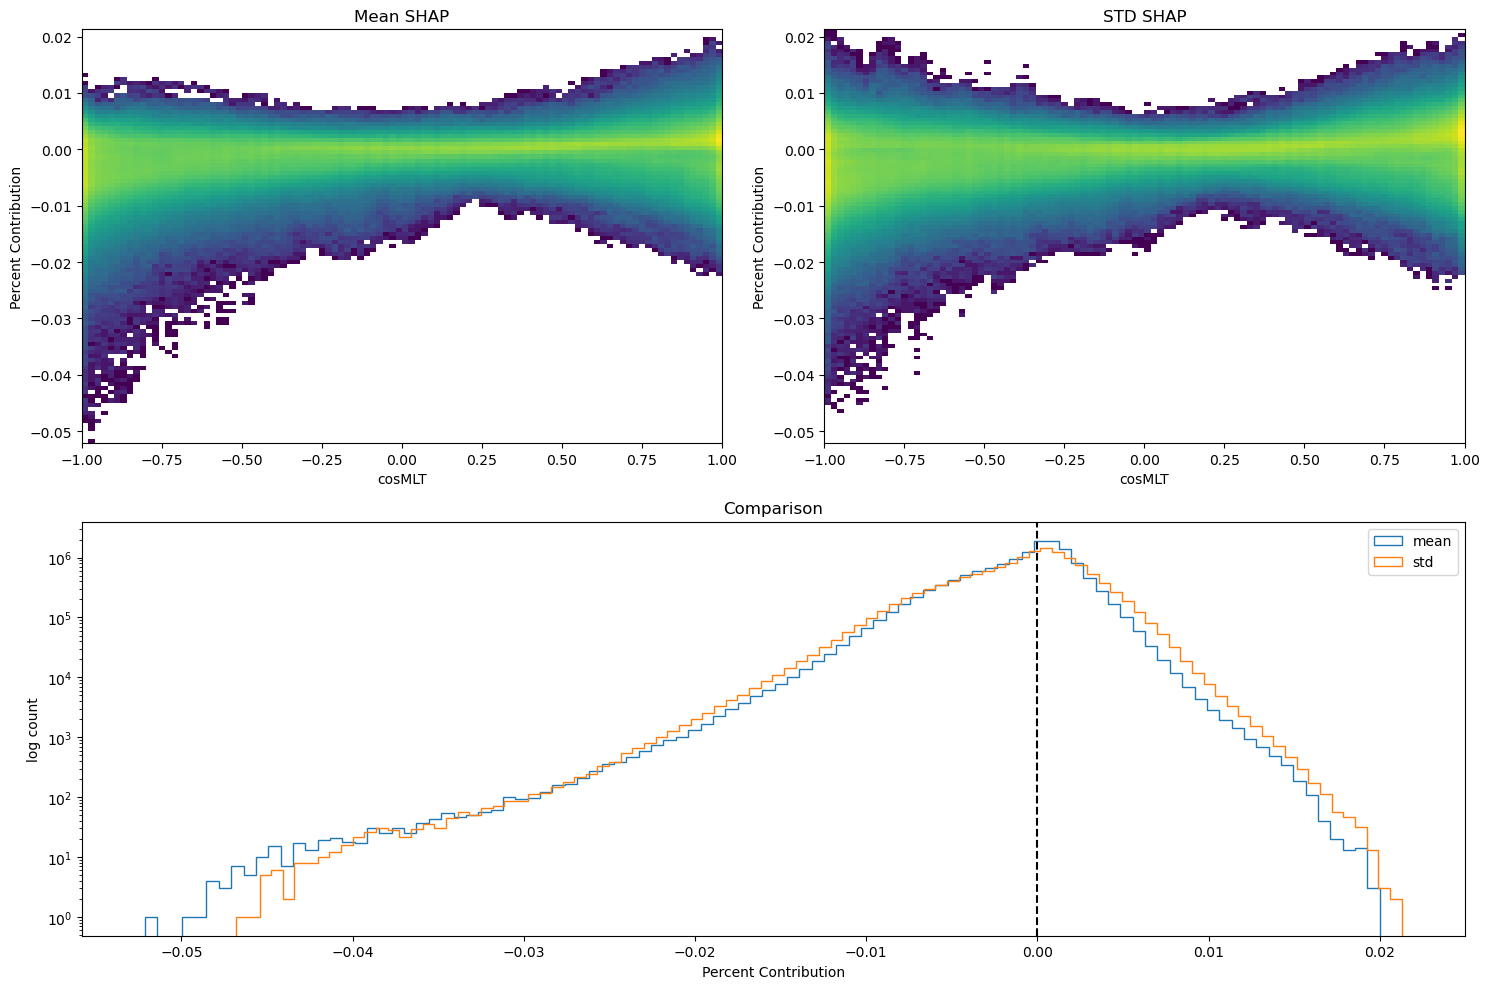

In [16]:
feature = 'cosMLT'

vmin = np.min([np.min(std_shap_df[feature]), np.min(mean_shap_df[feature])])
vmax = np.max([np.max(std_shap_df[feature]),np.max(mean_shap_df[feature])])

fig, axes = plt.subplot_mosaic("AB;DD", figsize=(15,10))
axes['A'].hist2d(transformed_X_df[feature], mean_shap_df[feature], bins=100, cmap='viridis', norm=mpl.colors.LogNorm())
axes['B'].hist2d(transformed_X_df[feature], std_shap_df[feature], bins=100, cmap='viridis', norm=mpl.colors.LogNorm())
plt.title(f'{feature}')
axes['A'].set_ylabel('Percent Contribution')
axes['A'].set_xlabel(feature)
axes['A'].set_xlim(np.min(transformed_X_df[feature]), np.max(transformed_X_df[feature]))
axes['A'].set_ylim(vmin, vmax)
axes['A'].set_title('Mean SHAP')

axes['B'].set_xlim(np.min(transformed_X_df[feature]), np.max(transformed_X_df[feature]))
axes['B'].set_ylim(vmin, vmax)
axes['B'].set_xlabel(feature)
axes['B'].set_ylabel('Percent Contribution')
axes['B'].set_title('STD SHAP')

axes['D'].set_title('Comparison')
axes['D'].hist(mean_shap_df[feature], bins=100, log=True, histtype='step', label='mean')
axes['D'].hist(std_shap_df[feature], bins=100, log=True, histtype='step', label='std')
axes['D'].set_ylabel('log count')
axes['D'].set_xlabel('Percent Contribution')
axes['D'].axvline(0, linestyle='--', color='k')
axes['D'].legend()

plt.tight_layout()
plt.savefig(f'plots/{feature}_swmag_shap_value_distributions.png')

# getting area under the curve of the 1D histograms
from sklearn.metrics import auc
mean_hist, mean_bins = np.histogram(mean_shap_df[feature], bins=100)
std_hist, std_bins = np.histogram(std_shap_df[feature], bins=100)
mean_area = auc(mean_bins[:-1], mean_hist)
std_area = auc(std_bins[:-1], std_hist)


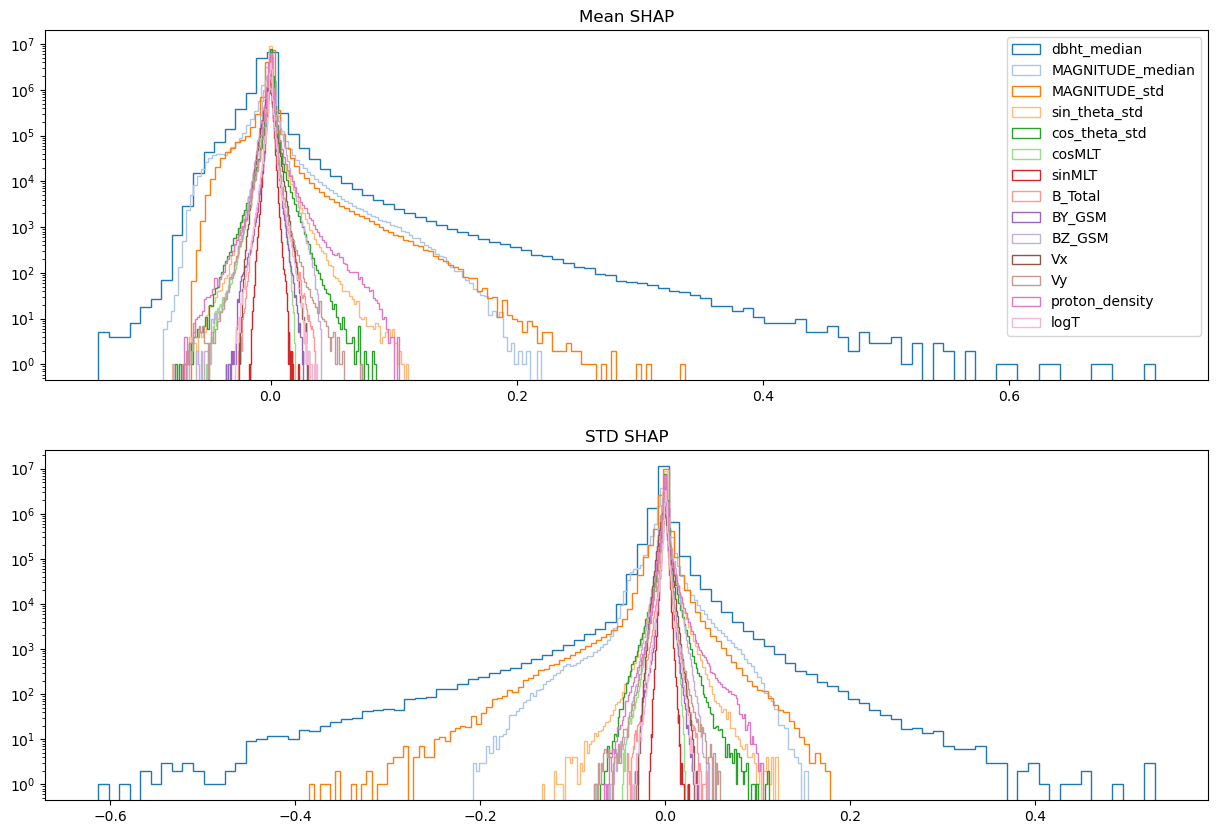

In [17]:
colors = sns.color_palette('tab20')

fig, axes = plt.subplots(2,1, figsize=(15,10))

for i, col in enumerate(shap_values['features']):
	axes[0].hist(mean_shap_df[col], bins=100, log=True, histtype='step', label=col, color=colors[i])
	axes[1].hist(std_shap_df[col], bins=100, log=True, histtype='step', label=col, color=colors[i])

axes[0].set_title('Mean SHAP')
axes[1].set_title('STD SHAP')

axes[0].legend()
plt.show()

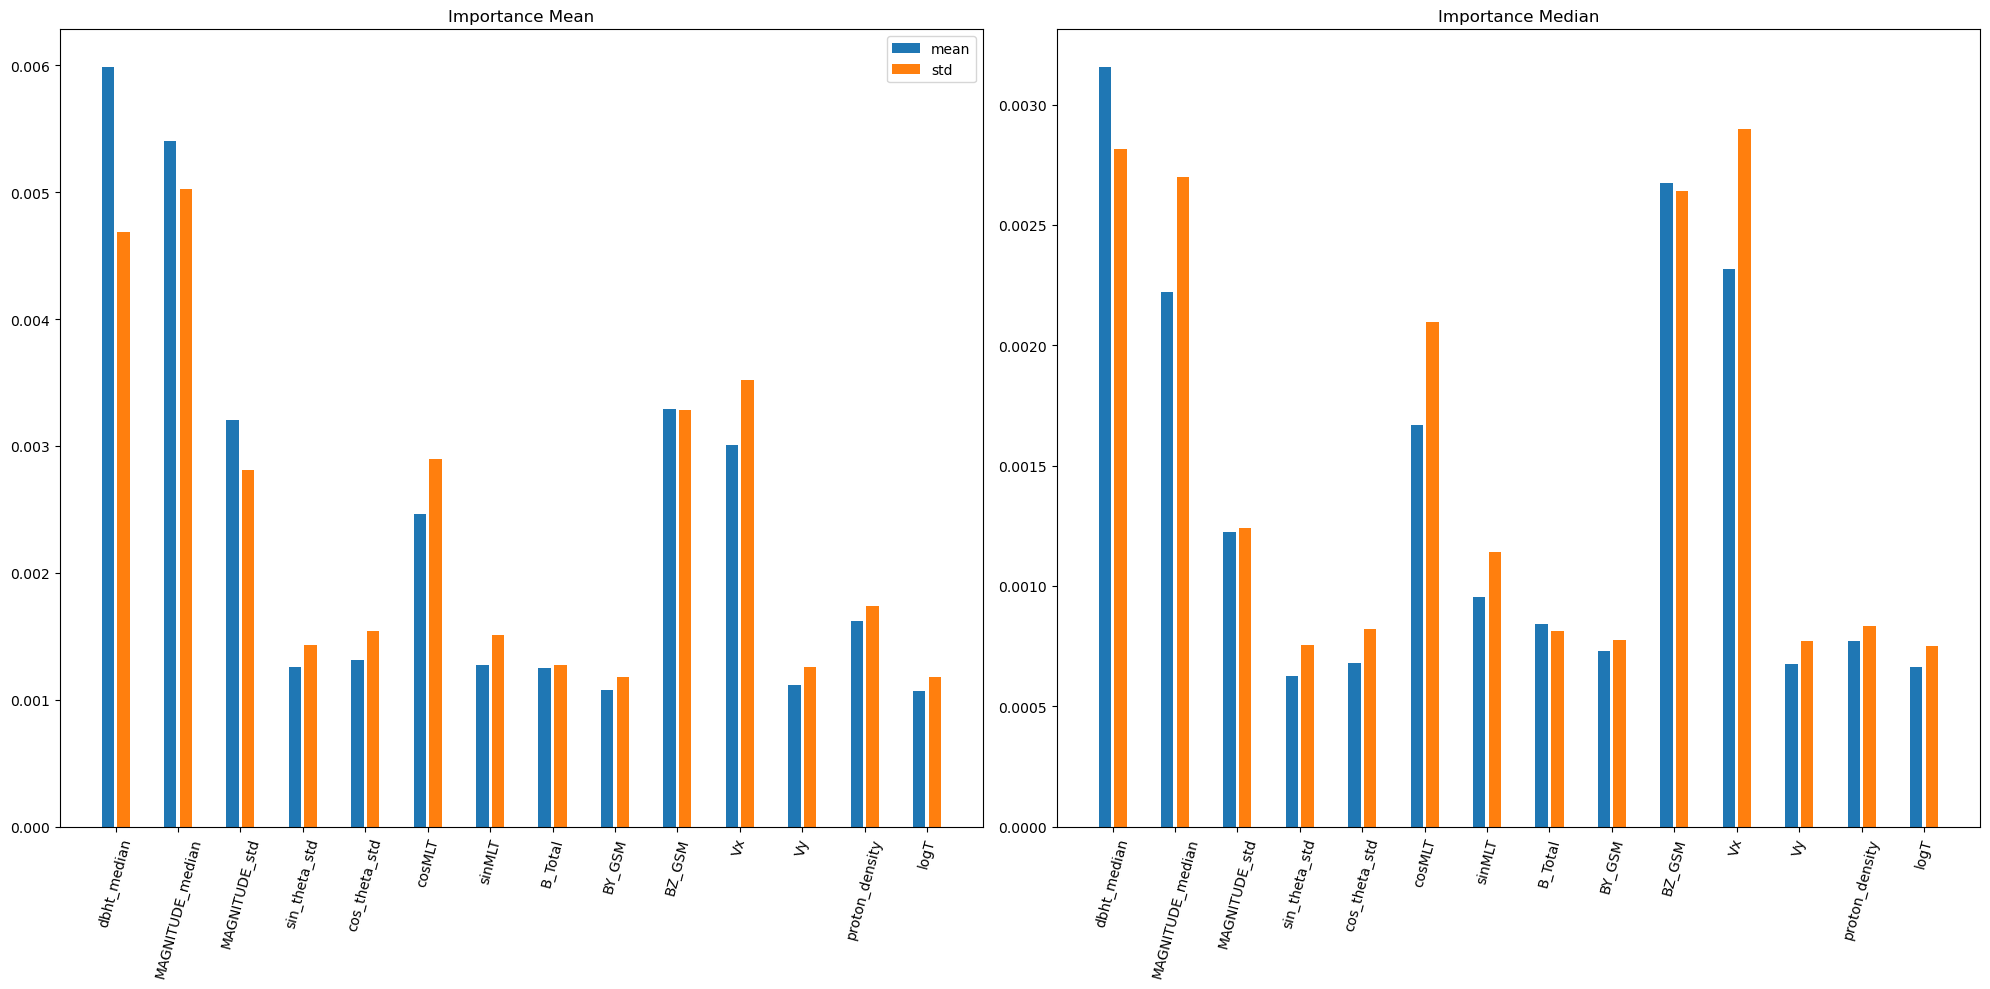

In [18]:
mean_importance_df = mean_shap_df.abs()
std_importance_df = std_shap_df.abs()

mean_mean_df = mean_importance_df.mean(axis=0)
std_mean_df = std_importance_df.mean(axis=0)

mean_median_df = mean_importance_df.median(axis=0)
std_median_df = std_importance_df.median(axis=0)


fig, axes = plt.subplots(1,2,figsize=(20,10))
x = [(i+1)*4 for i in range(len(mean_importance_df.columns))]
x_mean = [j-0.5 for j in x]
x_std = [k+0.5 for k in x]

axes[0].set_title('Importance Mean')
axes[0].bar(x_mean, mean_mean_df.values, label='mean')
axes[0].bar(x_std, std_mean_df.values, label='std')
axes[0].set_xticks(x)
axes[0].set_xticklabels(mean_importance_df.columns.tolist(), rotation=75)
axes[0].legend()

axes[1].set_title('Importance Median')
axes[1].bar(x_mean, mean_median_df.values, label='mean')
axes[1].bar(x_std, std_median_df.values, label='std')
axes[1].set_xticks(x)
axes[1].set_xticklabels(mean_importance_df.columns.tolist(), rotation=75)

plt.tight_layout()
plt.savefig('plots/swmag_feature_importance.png')

In [19]:
# individual_cluster_to_examine = 'canadian_cluster'
mean_shap, std_shap, X, mu, sigma, error = [], [], [], [], [], []
dataframes_to_make = ['mean_shap_df', 'std_shap_df', 'transformed_X_df', 'mu_df', 'sigma_df', 'error_df']
time_dict = {f'{feature}':{} for feature in shap_values['features']}

for feat in time_dict.keys():
	for df in dataframes_to_make:
		time_dict[feat][df] = pd.DataFrame()

for cluster in cluster_dict.keys():
	for reg, region in cluster_dict[cluster]['regions'].items():
		if f'{model_type}_shap' in region.keys():

			region[f'{model_type}_shap']['mean_shap'] = np.concatenate([region[f'{model_type}_shap']['shap_values'][i][0][:,:,:,:] for i in range(len(region[f'{model_type}_shap']['shap_values']))], axis=0)
			region[f'{model_type}_shap']['std_shap'] = np.concatenate([region[f'{model_type}_shap']['shap_values'][i][1][:,:,:,:] for i in range(len(region[f'{model_type}_shap']['shap_values']))], axis=0)

			for key in region[f'{model_type}_shap'].keys():
				if isinstance(region[f'{model_type}_shap'][key], torch.Tensor):
					region[f'{model_type}_shap'][key] = region[f'{model_type}_shap'][key].cpu().detach().numpy()

			try:
				region[f'{model_type}_shap']['mean_shap'] = region[f'{model_type}_shap']['mean_shap'].reshape(region[f'{model_type}_shap']['mean_shap'].shape[0], region[f'{model_type}_shap']['mean_shap'].shape[2], region[f'{model_type}_shap']['mean_shap'].shape[3])
				region[f'{model_type}_shap']['std_shap'] = region[f'{model_type}_shap']['std_shap'].reshape(region[f'{model_type}_shap']['std_shap'].shape[0], region[f'{model_type}_shap']['std_shap'].shape[2], region[f'{model_type}_shap']['std_shap'].shape[3])
				region[f'{model_type}_shap']['xtest'] = region[f'{model_type}_shap']['xtest'].reshape(region[f'{model_type}_shap']['xtest'].shape[0], region[f'{model_type}_shap']['xtest'].shape[2], region[f'{model_type}_shap']['xtest'].shape[3])

				mean_added = np.sum(np.sum(np.abs(region[f'{model_type}_shap']['mean_shap']), axis=1),axis=1)
				region[f'{model_type}_shap']['mean_shap'] = region[f'{model_type}_shap']['mean_shap']/mean_added[:,None,None]

				std_added = np.sum(np.sum(np.abs(region[f'{model_type}_shap']['std_shap']), axis=1),axis=1)
				region[f'{model_type}_shap']['std_shap'] = region[f'{model_type}_shap']['std_shap']/std_added[:,None,None]


			except:
				print('We already did this, skipping....')

			region_scaler = scalers[reg][model_type]['swmag_scaler']

			unbroadcasted_mu = results[reg]['swmag_results']['predicted_mean'].to_numpy()
			unbroadcasted_sigma = results[reg]['swmag_results']['predicted_std'].to_numpy()
			unbroadcasted_error = np.array(np.abs(results[reg]['swmag_results']['predicted_mean'] - results[reg]['swmag_results']['actual']))

			concatenated_mu = np.concatenate([np.concatenate([unbroadcasted_mu[:,np.newaxis]]*30, axis=1)[:,:,np.newaxis]]*14, axis=2)
			concatenated_sigma = np.concatenate([np.concatenate([unbroadcasted_sigma[:,np.newaxis]]*30, axis=1)[:,:,np.newaxis]]*14, axis=2)
			concatenated_error = np.concatenate([np.concatenate([unbroadcasted_error[:,np.newaxis]]*30, axis=1)[:,:,np.newaxis]]*14, axis=2)

			for v, var in enumerate(time_dict.keys()):
				time_dict[var]['mean_shap_df'] = pd.concat([time_dict[var]['mean_shap_df'], pd.DataFrame(region[f'{model_type}_shap']['mean_shap'][:,:,v])], axis=0)
				time_dict[var]['std_shap_df'] = pd.concat([time_dict[var]['std_shap_df'], pd.DataFrame(region[f'{model_type}_shap']['std_shap'][:,:,v])], axis=0)
				time_dict[var]['transformed_X_df'] = pd.concat([time_dict[var]['transformed_X_df'], \
																pd.DataFrame(np.array([region_scaler.inverse_transform(region[f'{model_type}_shap']['xtest'][i,:,:]) \
																for i in range(region[f'{model_type}_shap']['xtest'].shape[0])])[:,:,v])], axis=0)
				time_dict[var]['mu_df'] = pd.concat([time_dict[var]['mu_df'], pd.DataFrame(concatenated_mu[:,:,v])], axis=0)
				time_dict[var]['sigma_df'] = pd.concat([time_dict[var]['sigma_df'], pd.DataFrame(concatenated_sigma[:,:,v])], axis=0)
				time_dict[var]['error_df'] = pd.concat([time_dict[var]['error_df'], pd.DataFrame(concatenated_error[:,:,v])], axis=0)

			print(len(time_dict['Vx']['mean_shap_df'].columns))

			# mu.append(np.concatenate(concatenated_mu, axis=0))
			# sigma.append(np.concatenate(concatenated_sigma, axis=0))
			# error.append(np.concatenate(concatenated_error, axis=0))

			# mean_shap.append(np.concatenate(region[f'{model_type}_shap']['mean_shap'], axis=0))
			# std_shap.append(np.concatenate(region[f'{model_type}_shap']['std_shap'], axis=0))
			# X.append(region_scaler.inverse_transform(np.concatenate(region[f'{model_type}_shap']['xtest'], axis=0)))

time_columns = [f't-{30-i}' for i in range(0,30)]
for var in time_dict.keys():
	for df in time_dict[var]:
		print(time_dict[var][df].shape)
		print(len(time_dict[var][df].columns))
		time_dict[var][df].columns = time_columns
# mean_shap = np.concatenate(mean_shap, axis=0)
# std_shap = np.concatenate(std_shap, axis=0)
# X = np.concatenate(X, axis=0)
# mu = np.concatenate(mu, axis=0)
# sigma = np.concatenate(sigma, axis=0)
# error = np.concatenate(error, axis=0)

# mean_shap_df = pd.DataFrame(mean_shap, columns=shap_values['features'])
# std_shap_df = pd.DataFrame(std_shap, columns=shap_values['features'])
# transformed_X_df = pd.DataFrame(X, columns=shap_values['features'])
# mu_df = pd.DataFrame(mu, columns=shap_values['features'])
# sigma_df = pd.DataFrame(sigma, columns=shap_values['features'])
# error_df = pd.DataFrame(error, columns=shap_values['features'])



We already did this, skipping....
30
We already did this, skipping....
30
We already did this, skipping....
30
We already did this, skipping....
30
We already did this, skipping....
30
We already did this, skipping....
30
We already did this, skipping....
30
We already did this, skipping....
30
We already did this, skipping....
30
We already did this, skipping....
30
We already did this, skipping....
30
We already did this, skipping....
30
We already did this, skipping....
30
We already did this, skipping....
30
We already did this, skipping....
30
We already did this, skipping....
30
We already did this, skipping....
30
We already did this, skipping....
30
We already did this, skipping....
30
We already did this, skipping....
30
We already did this, skipping....
30
We already did this, skipping....
30
We already did this, skipping....
30
We already did this, skipping....
30
(461031, 30)
30
(461031, 30)
30
(461031, 30)
30
(461031, 30)
30
(461031, 30)
30
(461031, 30)
30
(461031, 30)
30


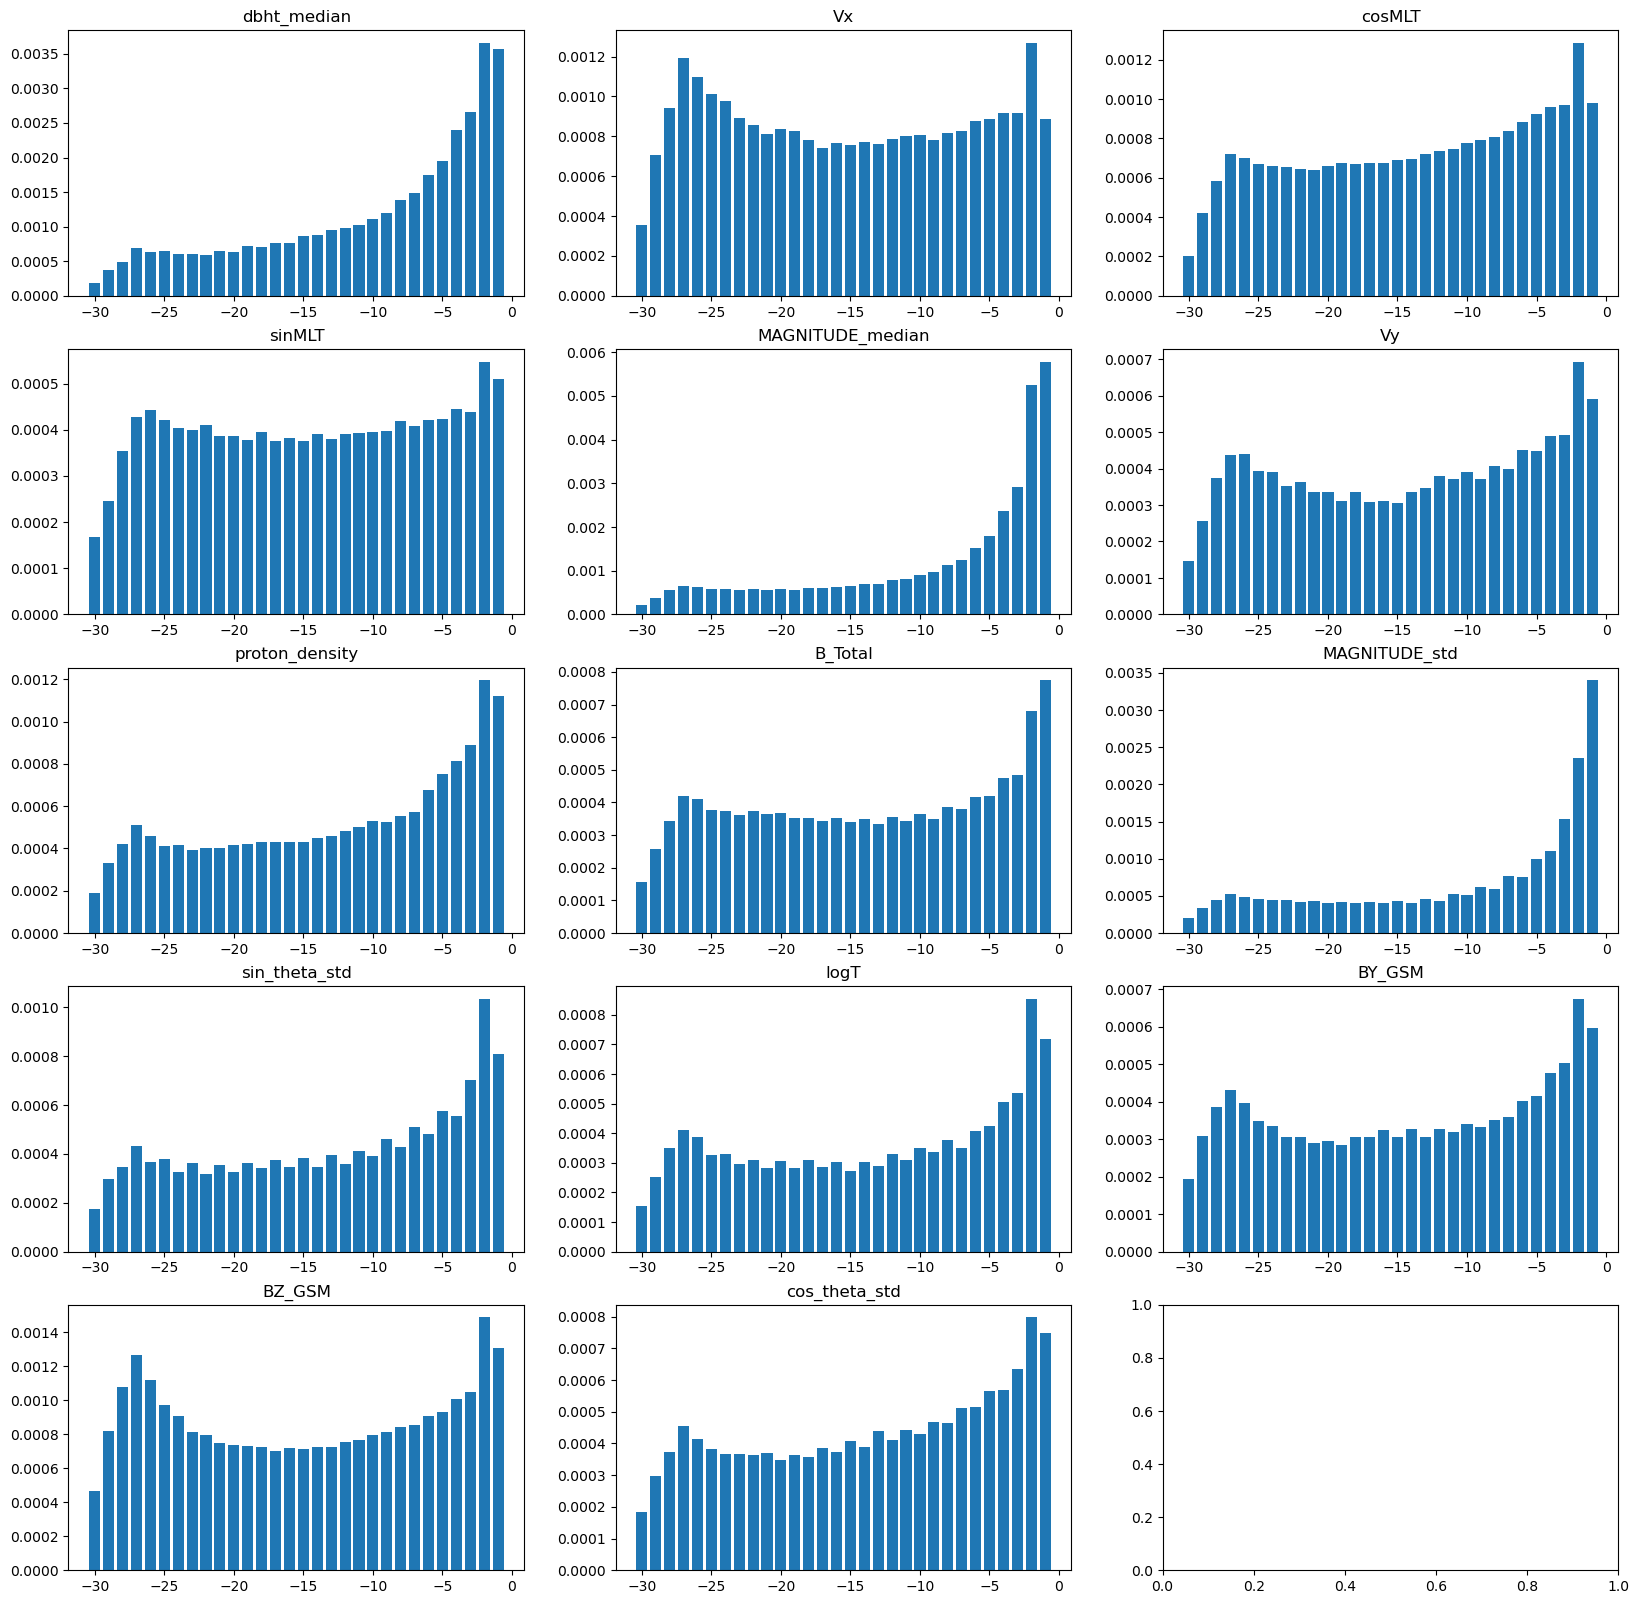

In [20]:
# var = 'BY_GSM'
df = 'std_shap_df'

fig, axes = plt.subplots(5, 3, figsize=(20,20))
for i, var in enumerate(time_dict.keys()):
	k = i%3
	j = i%5
	axes[j,k].bar([i-30 for i in range(0,30)], time_dict[var][df].abs().mean(axis=0))
	axes[j,k].set_title(var)
plt.savefig(f'plots/time_history_{df}.png')

In [21]:
for cluster in cluster_dict.values():
	for region in cluster['regions'].values():
		region['mean_lat'] = utils.getting_mean_lat(region['stations'])

Loading station NEW....
Loading station T19....
Loading station C10....
Loading station LET....
Loading station T03....
Loading station T43....
Loading station LET....
Loading station T03....
Loading station T43....
Loading station RED....
Loading station C06....
Loading station T43....
Loading station RED....
Loading station C06....
Loading station MEA....
Loading station T36....
Loading station GHB....
Loading station SKT....
Loading station STF....
Loading station ATU....
Loading station SKT....
Loading station STF....
Loading station ATU....
Loading station GDH....
Loading station STF....
Loading station ATU....
Loading station GDH....
Loading station UMQ....
Loading station GHB....
Loading station FHB....
Loading station NAQ....
Loading station RVK....
Loading station LYC....
Loading station DON....
Loading station JCK....
Loading station HAN....
Loading station MEK....
Loading station OUJ....
Loading station NUR....
Loading station MAS....
Loading station NOR....
Loading station 

In [22]:
for cluster in cluster_dict.keys():
	for name, region in cluster_dict[cluster]['regions'].items():
		print(f'{name} MLAT: {region["mean_lat"]}')

CAN-0 MLAT: 56.048641204833984
CAN-1 MLAT: 58.4619140625
CAN-2 MLAT: 60.34260940551758
GRL-0 MLAT: 72.20698547363281
GRL-1 MLAT: 73.52012634277344
GRL-2 MLAT: 74.75758361816406
GRL-3 MLAT: 67.90206909179688
FSC-0 MLAT: 62.93389129638672
FSC-1 MLAT: 59.16768264770508
FSC-2 MLAT: 66.23153686523438
FSC-3 MLAT: 66.09281158447266
FSC-4 MLAT: 65.2939453125
FSC-5 MLAT: 63.9111213684082
FSC-6 MLAT: 65.41779327392578
CEU-0 MLAT: 45.6979866027832
CEU-1 MLAT: 49.57994079589844
CEU-2 MLAT: 42.963829040527344
CEU-3 MLAT: 51.407283782958984
SVLB MLAT: 74.91368865966797
JPN-0 MLAT: 25.15587615966797
JPN-1 MLAT: 37.01019287109375
ALSK MLAT: 65.40392303466797
HUD-0 MLAT: 61.94677734375
HUD-1 MLAT: 71.61341857910156


['dbht_median', 'MAGNITUDE_median', 'MAGNITUDE_std', 'sin_theta_std', 'cos_theta_std', 'cosMLT', 'sinMLT', 'B_Total', 'BY_GSM', 'BZ_GSM', 'Vx', 'Vy', 'proton_density', 'logT']


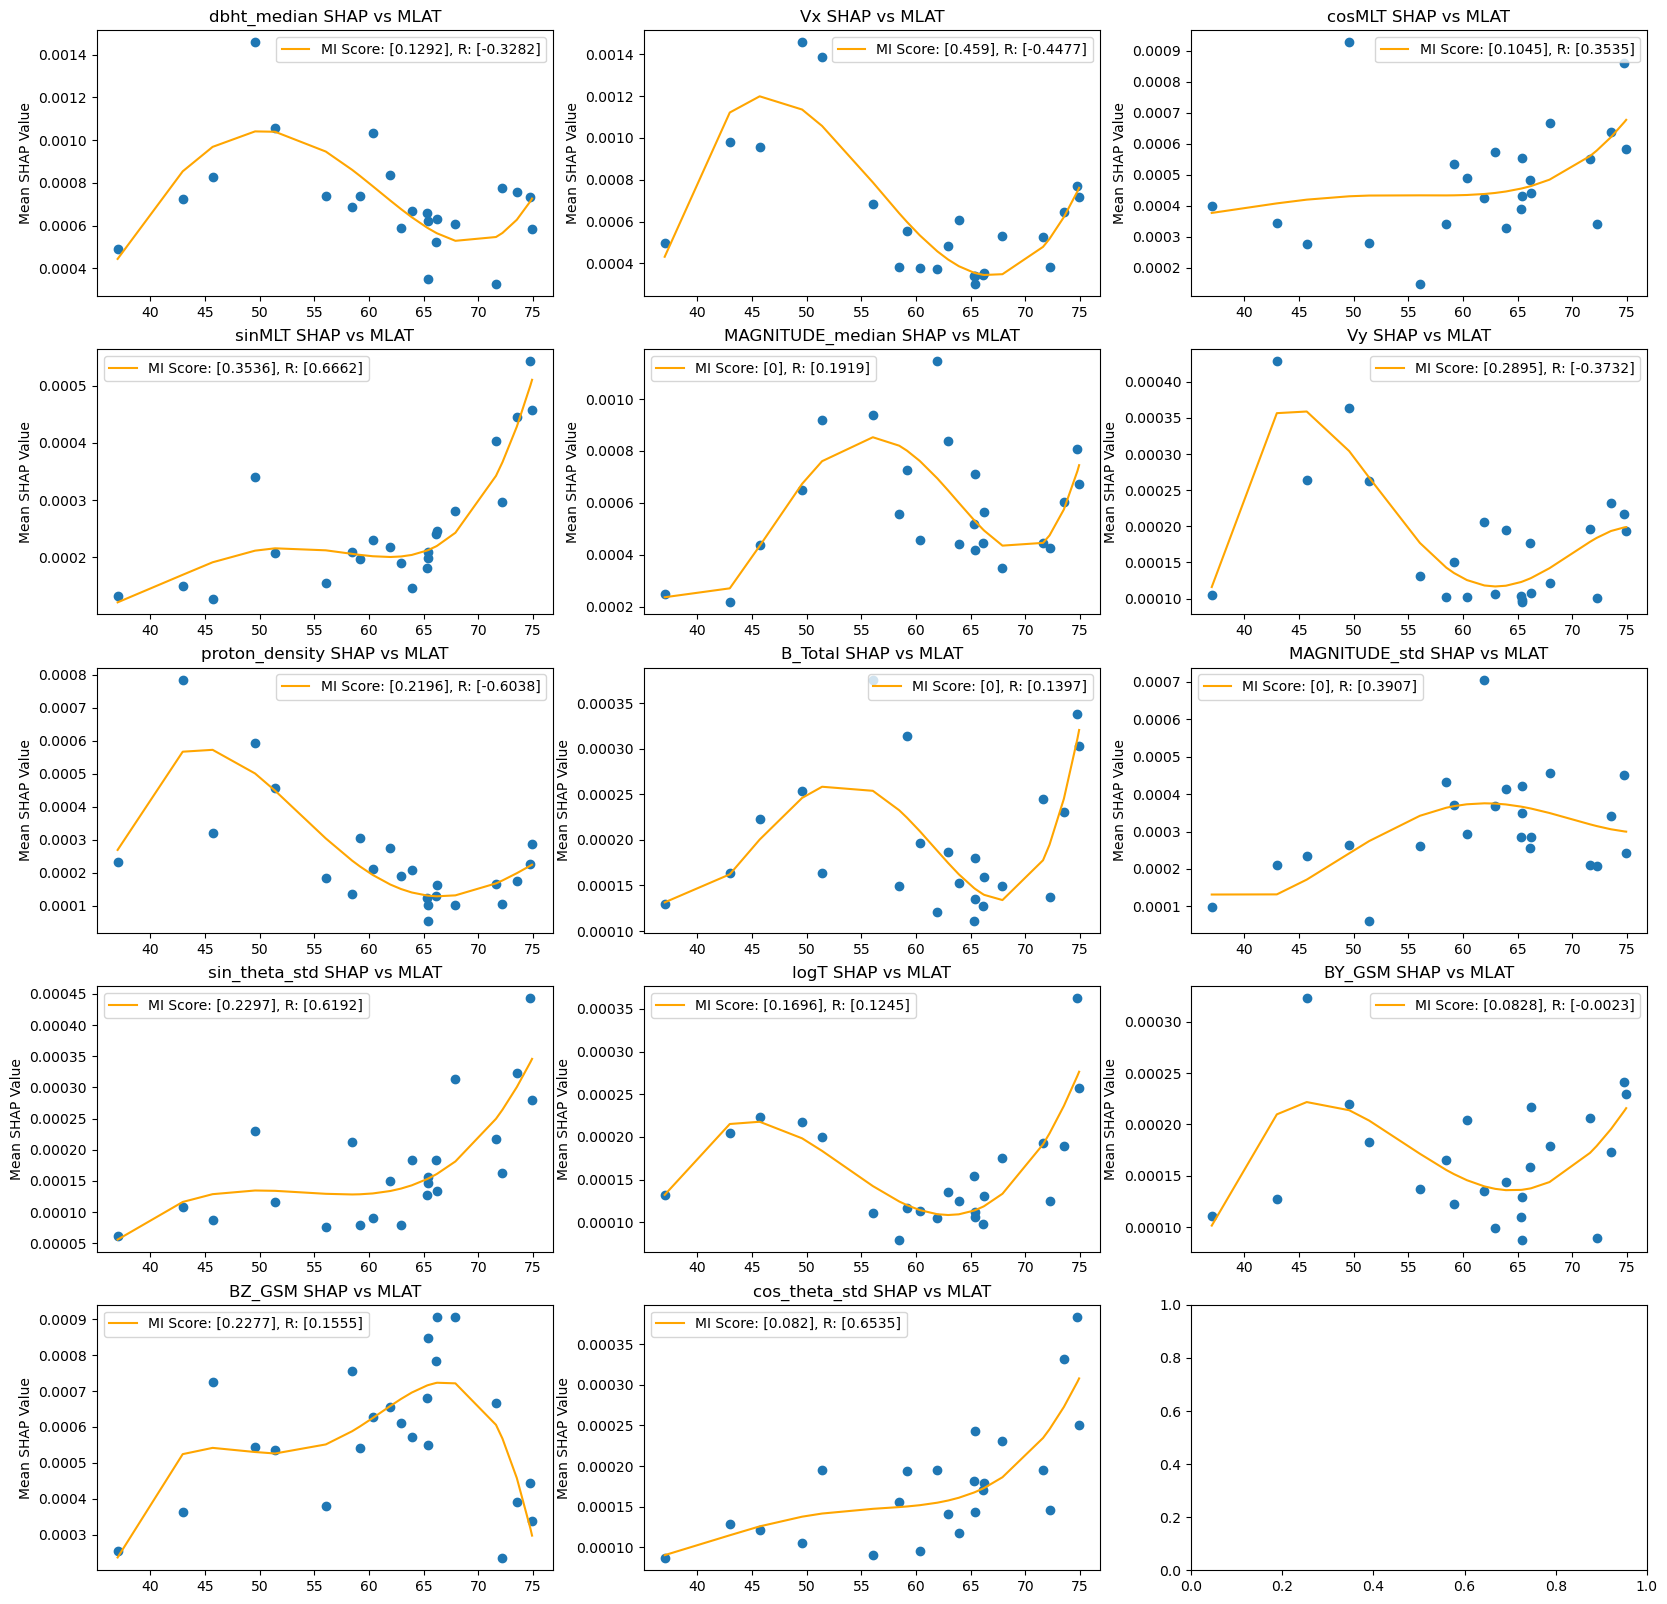

In [23]:
feature_list = cluster_dict['greenland_cluster']['regions']['GRL-0'][f'{model_type}_shap']['features'].tolist()
print(feature_list)
fig, axes = plt.subplots(5,3,figsize=(20,20))
for_MI = []
for i, var in enumerate(feature_list):
	j = i % 5
	k = i % 3
	shaps, lats = [], []

	for cluster in cluster_dict.values():
		for name, region in cluster['regions'].items():
			if name == 'JPN-0':
				continue
			if f'{model_type}_shap' in region.keys():
				region_shap_values = np.concatenate(region[f'{model_type}_shap']['mean_shap'], axis=0)[:, feature_list.index(var)]
				shaps.append(np.median(np.abs(region_shap_values)))
				lats.append(region['mean_lat'])

	plot_df = pd.DataFrame({'lats':lats, 'shaps':shaps}).sort_values(by='lats')
	z = np.polyfit(plot_df['lats'], plot_df['shaps'], 4)
	p = np.poly1d(z)
	MI_x = plot_df['lats'].to_numpy().reshape(-1,1)
	MI_y = (plot_df['shaps']*1000).to_numpy()
	for_MI.append(np.array(MI_y).reshape(-1,1))
	axes[j,k].plot(plot_df['lats'], p(plot_df['lats']), color='orange', label=f'MI Score: {mutual_info_regression(MI_x, MI_y).round(4)}, R: {r_regression(MI_x, MI_y).round(4)}')
	axes[j,k].scatter(plot_df['lats'], plot_df['shaps'])
	axes[j,k].set_ylabel('Mean SHAP Value')
	axes[j,k].set_title(f'{var} SHAP vs MLAT')
	axes[j,k].legend()
plt.savefig('plots/median_shap_vs_mlat.png')

In [86]:
plotting_df = pd.DataFrame()
mlt_arr, actual_arr, mlat_arr = [], [], []
for cluster in cluster_dict.keys():
	for reg, region in cluster_dict[cluster]['regions'].items():

		df = utils.loading_supermag(region['mlt_station'])
		dates = region['swmag_shap']['Date_UTC']

		cluster_dict[cluster]['regions'][reg]['test_mlt'] = df[df.index.isin(dates['Date_UTC'])]['MLT']
		# results[reg]['swmag_results'].set_index('dates', inplace=True)
		results[reg]['swmag_results']['MLT'] = cluster_dict[cluster]['regions'][reg]['test_mlt']
		results[reg]['swmag_results']['error'] = np.abs(results[reg]['swmag_results']['predicted_mean'] - results[reg]['swmag_results']['actual'])
		results[reg]['swmag_results']['mlat'] = cluster_dict[cluster]['regions'][reg]['mean_lat']
		if reg =='HUD-0' or reg=='CAN-2':
			print(reg)
			print(results[reg]['swmag_results']['actual'].mean())
			temp = results[reg]['swmag_results'][(results[reg]['swmag_results']['MLT'] >= 17) & (results[reg]['swmag_results']['MLT'] <= 18)]
			print(temp['actual'].mean())
			print(len(temp))
		plotting_df = pd.concat([plotting_df, results[reg]['swmag_results']], axis=0)

		unbroadcasted_mlt = results[reg]['swmag_results']['MLT'].to_numpy()
		unbroadcasted_actual = results[reg]['swmag_results']['actual'].to_numpy()
		unbroadcasted_mlat = results[reg]['swmag_results']['mlat'].to_numpy()

		concatenated_mlt = np.concatenate([np.concatenate([unbroadcasted_mlt[:,np.newaxis]]*30, axis=1)[:,:,np.newaxis]]*14, axis=2)
		concatenated_actual = np.concatenate([np.concatenate([unbroadcasted_actual[:,np.newaxis]]*30, axis=1)[:,:,np.newaxis]]*14, axis=2)

		# mlt_arr.append(np.concatenate(concatenated_mlt, axis=0))
		# actual_arr.append(np.concatenate(concatenated_actual, axis=0))

		mlt_arr.append(np.repeat(results[reg]['swmag_results']['MLT'].to_numpy(), 30))
		actual_arr.append(np.repeat(results[reg]['swmag_results']['actual'].to_numpy(), 30))
		mlat_arr.append(np.repeat(results[reg]['swmag_results']['mlat'].to_numpy(), 30))

mlt_arr = np.concatenate(mlt_arr, axis=0)
actual_arr = np.concatenate(actual_arr, axis=0)
mlat_arr = np.concatenate(mlat_arr, axis=0)

# mlt_df = pd.DataFrame(mlt_arr, columns=shap_values['features'])
# actual_df = pd.DataFrame(actual_arr, columns=shap_values['features'])

plotting_mlt_mlat_shap_mean = mean_shap_df.copy()
plotting_mlt_mlat_shap_mean['MLT'] = mlt_arr
plotting_mlt_mlat_shap_mean['mlat'] = mlat_arr
plotting_mlt_mlat_shap_mean['actual'] = actual_arr


Loading station NEW....
Loading station LET....
Loading station MEA....
CAN-2
0.1855382
0.113708824
941
Loading station STF....
Loading station GDH....
Loading station GDH....
Loading station NAQ....
Loading station LYC....
Loading station NUR....
Loading station ABK....
Loading station ABK....
Loading station ABK....
Loading station ABK....
Loading station ABK....
Loading station BEL....
Loading station BEL....
Loading station HRB....
Loading station WNG....
Loading station HRN....
Loading station KNY....
Loading station MMB....
Loading station CMO....
Loading station PIN....
HUD-0
0.21549506
0.6426117
291
Loading station BLC....


In [83]:
temp = plotting_df[(plotting_df['mlat']>60) & (plotting_df['mlat']<62)]
temp = temp[(temp['MLT']>=17) & (temp['MLT']<=18)]

print(len(temp))
print(len(plotting_df))

565
461031


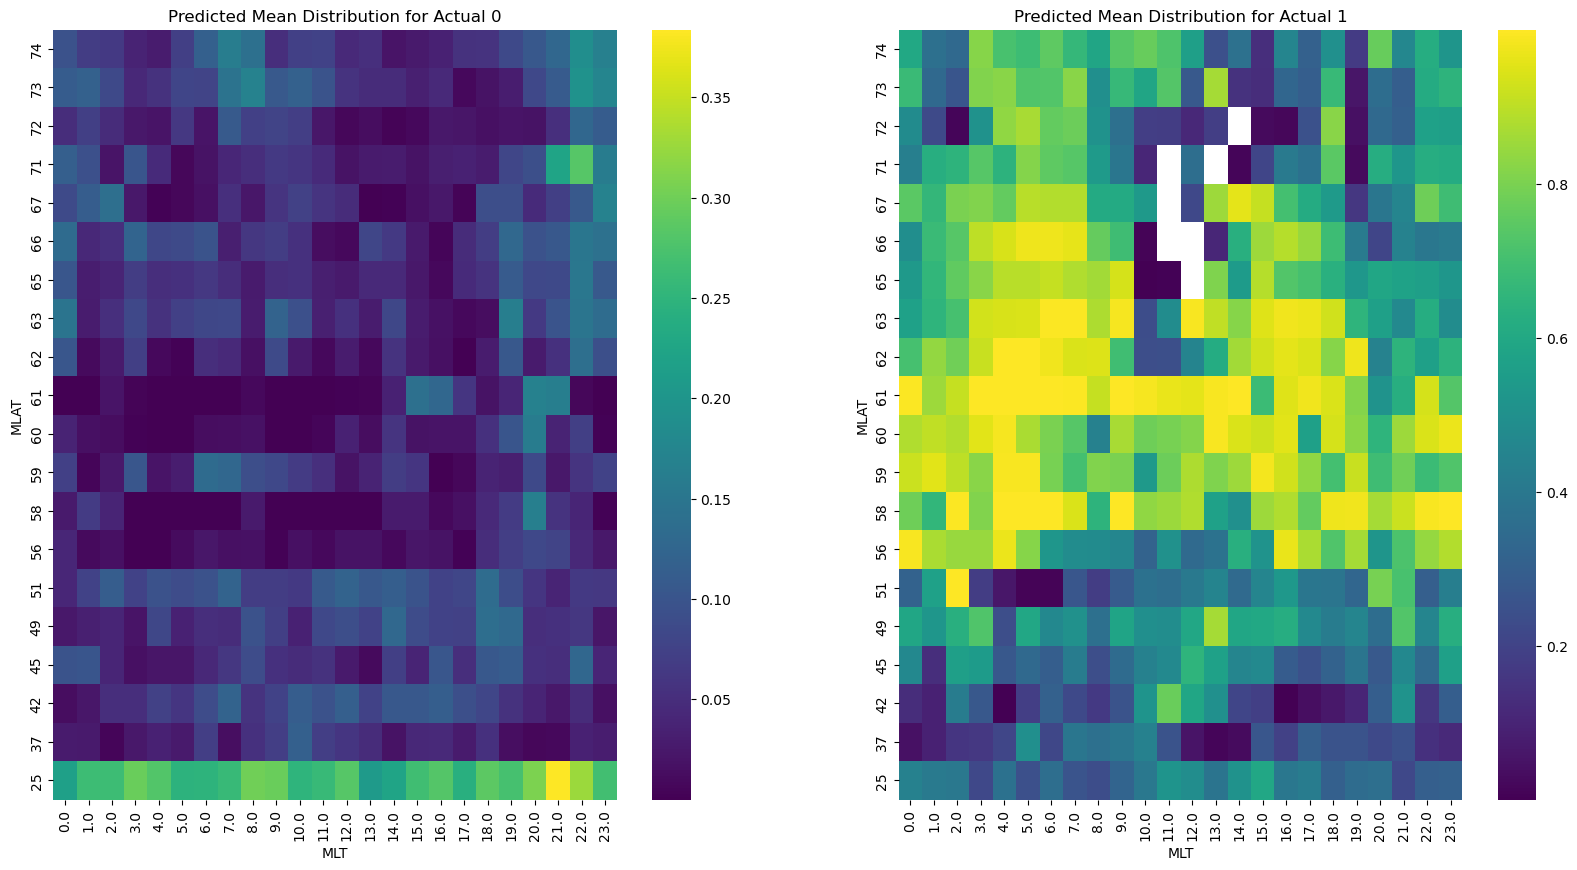

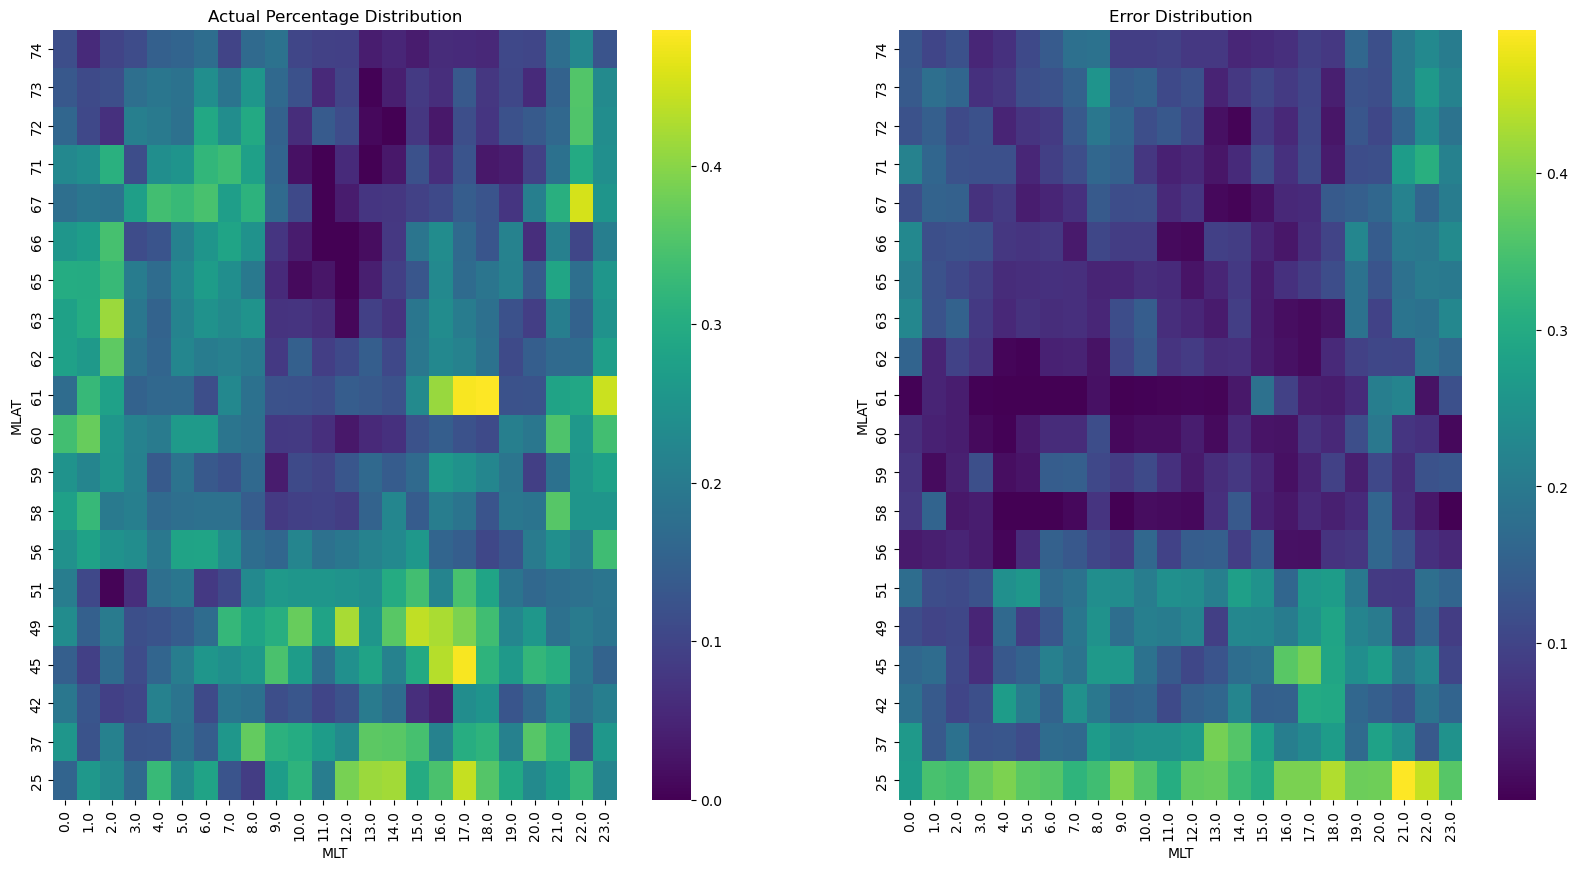

In [71]:
plotting_df['MLT'] = plotting_df['MLT'].round(0)
plotting_df['mlat'] = plotting_df['mlat'].astype(int)
plotting_df['MLT'].replace({24:0}, inplace=True)

actual_0_plotting_df = plotting_df[plotting_df['actual']==0]
actual_1_plotting_df = plotting_df[plotting_df['actual']==1]

pivot_table_0 = actual_0_plotting_df.pivot_table(index='mlat', columns='MLT', values='predicted_mean', aggfunc='mean')
pivot_table_1 = actual_1_plotting_df.pivot_table(index='mlat', columns='MLT', values='predicted_mean', aggfunc='mean')
perc_table = plotting_df.pivot_table(index='mlat', columns='MLT', values='actual', aggfunc='mean')
error_table = plotting_df.pivot_table(index='mlat', columns='MLT', values='error', aggfunc='mean')

fig, axes = plt.subplots(1,2,figsize=(20,10))
sns.heatmap(pivot_table_0, ax=axes[0], cmap='viridis')
# inverting the y axis to make it look like a real MLAT plot
axes[0].invert_yaxis()
axes[0].set_title('Predicted Mean Distribution for Actual 0')
axes[0].set_xlabel('MLT')
axes[0].set_ylabel('MLAT')

sns.heatmap(pivot_table_1, ax=axes[1], cmap='viridis')
axes[1].invert_yaxis()
axes[1].set_title('Predicted Mean Distribution for Actual 1')
axes[1].set_xlabel('MLT')
axes[1].set_ylabel('MLAT')

plt.show()

fig, axes = plt.subplots(1,2,figsize=(20,10))
sns.heatmap(perc_table, ax=axes[0], cmap='viridis')
axes[0].invert_yaxis()
axes[0].set_title('Actual Percentage Distribution')
axes[0].set_xlabel('MLT')
axes[0].set_ylabel('MLAT')

sns.heatmap(error_table, ax=axes[1], cmap='viridis')
axes[1].invert_yaxis()
axes[1].set_title('Error Distribution')
axes[1].set_xlabel('MLT')
axes[1].set_ylabel('MLAT')

plt.show()

In [94]:
var = 'proton'

plotting_mlt_mlat_shap_mean['MLT'] = plotting_mlt_mlat_shap_mean['MLT'].round(0)
plotting_mlt_mlat_shap_mean['mlat'] = plotting_mlt_mlat_shap_mean['mlat'].astype(int)
plotting_mlt_mlat_shap_mean['MLT'].replace({24:0}, inplace=True)

actual_0_plotting_df = plotting_mlt_mlat_shap_mean[plotting_mlt_mlat_shap_mean['actual']==0]
actual_1_plotting_df = plotting_mlt_mlat_shap_mean[plotting_mlt_mlat_shap_mean['actual']==1]

pivot_table_0 = actual_0_plotting_df.pivot_table(index='mlat', columns='MLT', values=var, aggfunc='mean')
pivot_table_1 = actual_1_plotting_df.pivot_table(index='mlat', columns='MLT', values=var, aggfunc='mean')

vmax = np.max([np.nanmax(pivot_table_0.values), np.nanmax(pivot_table_1.values)])
vmin = np.min([np.nanmin(pivot_table_0.values), np.nanmin(pivot_table_1.values)])

vlim = np.max([np.abs(vmin), np.abs(vmax)])

fig, axes = plt.subplots(1,2,figsize=(20,10))
sns.heatmap(pivot_table_0, ax=axes[0], cmap='bwr', vmin=-vlim, vmax=vlim)
# inverting the y axis to make it look like a real MLAT plot
axes[0].invert_yaxis()
axes[0].set_title(f'{var} SHAP Value for Actual 0')
axes[0].set_xlabel('MLT')
axes[0].set_ylabel('MLAT')

sns.heatmap(pivot_table_1, ax=axes[1], cmap='bwr', vmin=-vlim, vmax=vlim)
axes[1].invert_yaxis()
axes[1].set_title(f'{var} SHAP Value for Actual 1')
axes[1].set_xlabel('MLT')
axes[1].set_ylabel('MLAT')

plt.show()
